# Cadence Feature Extraction Pipeline

# Packages and Config

In [2]:
import sys
import random
import pandas as pd
import os
import pathlib
import yaml
import disvoice
import librosa 
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import scipy.stats as stats

from pydub import AudioSegment, silence
from pydub.playback import play

# Configure display and plotting options
pd.set_option('display.max_rows', None)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

# Set WD
try:
    os.chdir('cadence_modelling/')
except:
    print(f'WD: {os.getcwd()}')

# Import configs
with open('/home/ubuntu/configs/config.yaml', 'r') as file:
    inputs = yaml.safe_load(file)

WD: /home/ubuntu/testing-code/cadence-modellling


# Ingestion of files

In [93]:
len(all_wav_files)

11457

In [131]:
# Begin with list of files; here we use an example template while we await the full class ouput
def extract_input_files(data_input_path):

    all_wav_files = pathlib.Path(data_input_path)
    all_wav_files = list(all_wav_files.rglob("*.wav")) + list(all_wav_files.rglob("*.WAV"))
    all_wav_files = [str(file) for file in all_wav_files]

    #real_resampled_wav_files = [file for file in all_wav_files if 'TIMIT converted' in file]
    #fake_resampled_wav_files = [file for file in all_wav_files if not 'TIMIT converted' in file]

    flags = [1 if 'TIMIT converted' in str(item) else 0 for item in all_wav_files]
    
    return all_wav_files, flags #real_resampled_wav_files, fake_resampled_wav_files, flags

all_wav_files, flags = extract_input_files('../../data/TIMIT-fake')

# 1. Set thresholds

In [94]:
silence_threshold = 0.005 # 0.5 percent (0.005), from '0_cadence_modelling.ipynb'. Previously we used 0.2% in the truncation step.
low_pass_filter_cutoff = 10 # from '1_cadence_LJ.ipynb'

# 2. Normalise amplitudes

In [34]:
def normalize_audio_amplitudes(all_wav_files):
    normalized_audios = []
    
    for file in all_wav_files:
        sample = librosa.load(file)[0]
        max_abs = np.max(np.abs(sample))
        normalized_sample = sample/max_abs
        normalized_audios.append(normalized_sample)
        
    return normalized_audios

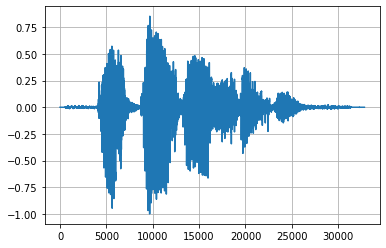

In [35]:
normalized_audios = normalize_audio_amplitudes(all_wav_files)

# Perform check
i = 0
plt.grid()
plt.plot(np.arange(len(normalized_audios[i])), normalized_audios[i])
plt.title(f"")
plt.show()

# 3. Truncate silences at start and end of clip

In [64]:
def truncate_silences(normalized_audios, silence_threshold, window_size=100):
    truncated_audios = []
    start_ids = []
    end_ids = []
    
    for audio in normalized_audios:
        for j in range(len(audio)):
            roll_average = np.mean(np.abs(audio[j:j+window_size]))
            if roll_average > silence_threshold:
                truncation_id_start = j
                break

        for j in reversed(range(len(audio))):
            roll_average = np.mean(np.abs(audio[j-window_size:j]))
            if roll_average > silence_threshold:
                truncation_id_end = j-window_size
                break
        truncated_audios.append(audio[truncation_id_start:truncation_id_end])
        start_ids.append(truncation_id_start)
        end_ids.append(truncation_id_end)
    
    return truncated_audios, start_ids, end_ids

In [97]:
truncated_audios, start_ids, end_ids = truncate_silences(normalized_audios, silence_threshold, window_size=100)

# Test
j = 9770
i = 9782

for item in np.arange(j, i):
    print(item)
    plt.grid()
    plt.plot(np.arange(len(normalized_audios[item])), normalized_audios[item])
    plt.title(f"")
    plt.axvline(x=start_ids[item], color='r', linestyle='-')
    plt.axvline(x=end_ids[item], color='r', linestyle='-')
    plt.plot(np.arange(len(truncated_audios[item])), truncated_audios[item])
    plt.show()

KeyboardInterrupt: 

# 4. Features: Pause Extraction

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def get_silence(audio, percent):
    thresh = max(abs(audio))*percent
    
    moving_avg = moving_average(abs(audio), 100)

    silent = np.where(abs(moving_avg) < thresh)
    voiced = np.where(abs(moving_avg) >= thresh)
    
    pct_pause = len(silent[0])*100/(len(silent[0])+len(voiced[0]))
    pct_voiced = len(voiced[0])*100/(len(silent[0])+len(voiced[0]))
    ratio_pause_voiced = len(silent[0])/len(voiced[0]) 

    return pct_pause, pct_voiced, ratio_pause_voiced

def get_silence_spread(audio, percent):

    thresh = max(abs(audio))*percent
    
    moving_avg = moving_average(abs(audio), 100)

    silent_windows = np.where(moving_avg < thresh)
    moving_avg[silent_windows] = 0
    silence_count = 0
    silence_counts = []
    
    for i in range(len(moving_avg)-1):
        item = moving_avg[i]
        next_item = moving_avg[i+1]
        
        if item != 0 and next_item == 0:
            silence_count = 0
            
        elif item == 0 and next_item == 0:
            silence_count += 1
            
        elif item == 0 and next_item != 0:
            silence_counts.append(silence_count)
        
        else:
            continue  
    
    # Get spreads/means and normalise
    spread_of_silences = np.std(silence_counts)/len(moving_avg)
    mean_of_silences = np.mean(silence_counts)/len(moving_avg)
    n_pauses = len(silence_counts)
        
    return spread_of_silences, mean_of_silences, silence_counts, n_pauses
    

# Balance data

In [136]:
def balance_data(all_wav_files):
    
    folders = set([all_wav_files[i].split('_')[-1].split('.')[0] for i in range(len(all_wav_files))])
    
    real_resampled_wav_files = [file for file in all_wav_files if 'TIMIT converted' in file]
    fake_resampled_wav_files = [file for file in all_wav_files if not 'TIMIT converted' in file]
    
    # Ensure we take the same number of each phrase for real and fake, downsample the fake files 
    balanced_real_resampled_wav_files = []
    balanced_fake_resampled_wav_files = []
    
    for folder in folders:
        real_examples = [file for file in real_resampled_wav_files if f'_{folder}.' in file]
        fake_examples = [file for file in fake_resampled_wav_files if f'_{folder}.' in file]

        if len(real_examples) > len(fake_examples):
            real_examples = random.sample(real_examples, len(fake_examples))
        else:
            fake_examples = random.sample(fake_examples, len(real_examples))

        [balanced_real_resampled_wav_files.append(file) for file in real_examples]
        [balanced_fake_resampled_wav_files.append(file) for file in fake_examples]
    
    rebalanced_wav_files = balanced_real_resampled_wav_files + balanced_fake_resampled_wav_files
    
    return rebalanced_wav_files

rebalanced_wav_files = balance_data(all_wav_files)

# Quick test
#print(len(balanced_real_resampled_wav_files), len(balanced_fake_resampled_wav_files))

#folders = set([real_resampled_wav_files[i].split('_')[-1].split('.')[0] for i in range(len(real_resampled_wav_files))])

#for folder in folders:
#    real_fols = [item for item in balanced_real_resampled_wav_files if item.lower().endswith(f'{folder.lower()}.wav')]
#    fake_fols = [item for item in balanced_fake_resampled_wav_files if item.lower().endswith(f'{folder.lower()}.wav')]
#    if len(real_fols) != len(fake_fols):
#           print(len(real_fols), len(fake_fols))

In [ ]:
def run_all_files(balanced_real_resampled_wav_files, balanced_fake_resampled_wav_files, function):
    # Instantiate results - r=real, f=fake
    r1s = []
    f1s = []

    real_files = []
    fake_files = []

    for item in real_examples:
        r1, r2, r3 = function(librosa.load(item)[0], percent)
        r1s.append(r1)

    for item in fake_examples:
        f1, f2, f3 = function(librosa.load(item)[0], percent
        f1s.append(f1)
    
    return r1s, f1s

# Run full pipeline within sincle function

In [ ]:
def run_cadence_feature_extraction_pipeline(data_input_path = '../../data/TIMIT-fake', silence_threshold = 0.005, low_pass_filter_cutoff = 10):
    
    ## PREPROCESS
    # Extract input files
    all_wav_files, flags = extract_input_files(data_input_path)
    
    # Balance data
    rebalanced_wav_files = balance_data(all_wav_files)
    
    # Normalise amplitudes
    normalized_audios = normalize_audio_amplitudes(all_wav_files)
    
    # Truncate silences
    truncated_audios, start_ids, end_ids = truncate_silences(normalized_audios, silence_threshold, window_size=100)
    
    ## FEATURE ENGINEERING
    #
    
    

# X. Test on timit non-processed to see if same results arise